# MNIST Auto-Encoder

## Pre-requisites

In [1]:
! pip3 install cloudmesh-installer
! pip3 install cloudmesh-common

     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 133kB 32.1MB/s 
     |████████████████████████████████| 870kB 32.9MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for python-hostlist: filename=python_hostlist-1.21-cp36-none-any.whl size=38931 sha256=178714a9795bc65441e9c37ea25250ea4c5687e434fcf354525aada31f63b398
  Stored in directory: /root/.cache/pip/wheels/0b/5b/55/ddcf52288f0b10f4564ca1b2531594ff7ccc65f487ba8dc437
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8210 sha256=838223cf6acbeb0cad334caeca285e0d7fdd3b3c55fb0b3548c70f29769ae78f
  Stored in directory: /root/.cache/pip/wheels/e1/c6/9b/651d8a21d59b51a75ab9c070838f9231b8126421bc0569af47
Successfully built python-hostlist ordered-set
ERROR: pytest-cov 2.11.1 has requirement coverage>=5.2.1, but you'll have covera

## Import Libraries

In [2]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

## Pre-Process Data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
hidden_units = [32, 64]

11493376/11490434 [==============================] - 0s 0us/step


## Define Model

In [5]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Dense(hidden_units[0], activation='relu')(x)
x = Dense(hidden_units[1], activation='relu')(x)

shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)


latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Dense(hidden_units[0], activation='relu')(x)
x = Dense(hidden_units[1], activation='relu')(x)

outputs = Dense(1, activation='relu')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

autoencoder.compile(loss='mse', optimizer='adam')


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
dense_3 (Dense)              (None, 28, 28, 64)        2112      
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                802832    
Total params: 805,008
Trainable params: 805,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output 

## Train

In [6]:
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size)

1875/1875 [==============================] - 112s 60ms/step - loss: 0.0268 - val_loss: 0.0131


## Test

In [8]:
x_decoded = autoencoder.predict(x_test)

## Visualize

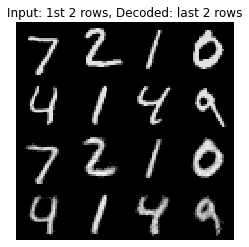

In [9]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()